<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/split-and-simple-perturb/sequences/P2C1_Optimization/P2C1_Sequence4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is part of a test for an upcoming text book on computational neuroscience from an optimization and learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as an optimization algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

___
# **2.1.4: Learning Behaviour as a form of High Dimensional Optimization**

### Objective: Explicitly connect the kinds of simple optimization process we saw in the previous sequences to learning adaptive behaviours.

In this sequence we will:

* Introduce a slightly more complex version of the strike-no-strike problem where the decision depends on 64 features instead of 1, and develop a simple artificial neural network that can solve this problem

* Use perturb-measure-step to train this network

* Investigate different times scales of learning and function evaluation.


# Setup

Run the following cell to setup and install the various dependencies and helper functions for this .

In [1]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**
!apt install libgraphviz-dev > /dev/null 2> /dev/null #colab
!pip install ipympl pygraphviz vibecheck datatops jupyterquiz ucimlrepo > /dev/null 2> /dev/null #google.colab

import asyncio
import requests
from requests.exceptions import RequestException
import numpy as np
import itertools
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
from matplotlib.animation import FuncAnimation
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
import pygraphviz as pgv
import ipywidgets as widgets
import time
import logging
import random
import os
import copy
import torch
import warnings
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from io import BytesIO
from enum import Enum
from scipy.spatial.distance import cdist
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown, HTML, Image
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm
from ucimlrepo import fetch_ucirepo

data_set = fetch_ucirepo(id=80)
X = data_set.data.features.values
# Translate the data to have a minimum of 0
X_translated = X - X.min()
# Scale the data to have a range from 0 to 12 (which is 6 - (-6))
scaling_factor = 12 / (X.max() - X.min())
X_scaled = X_translated * scaling_factor
# Finally, shift the data to be centered between -6 and 6
X_final = X_scaled - 6

y = data_set.data.targets.values
rng = np.random.default_rng(seed=2021)
scramble_permutation = rng.permutation(X.shape[1])
Xs = X_final[:, scramble_permutation]
y1 = y % 2
y2 = np.array(y >= 5, dtype=y.dtype)
simple_index = ((y.flatten()==1) | (y.flatten()==0))
X_simple = Xs[simple_index]
y1_simple = y1[simple_index]
# if you only had one feature which would likely be best for discrimination
epsilon = 10
class_a_sep = np.mean(X_simple[y1_simple.flatten() == 1, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 1, :], axis=0) + epsilon)
class_b_sep = np.mean(X_simple[y1_simple.flatten() == 0, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 0, :], axis=0) + epsilon)
best_feature = np.argmax(class_a_sep - class_b_sep)
print(f'Best feature is {best_feature}')
X_simple_1_feature = X_simple[:, [best_feature]]

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("This notebook isn't using and doesn't need a GPU. Good.")
  else:
    print("GPU is enabled in this notebook but not needed.")
    print("If possible, in the menu under `Runtime` -> ")
    print("`Change runtime type.`  select `CPU`")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import data_table
  data_table.disable_dataframe_formatter()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P2C1_S2"

Best feature is 21
Random seed 2021 has been set.
This notebook isn't using and doesn't need a GPU. Good.
Running in colab


# 2.1.4.1 Learning Strike-No-Strike with Perturb-Measure-Step.

Now that we know a bit about optimization in higher-dimensions we are going to introduce a harder, higher-dimensional version of our strike-no-strike problem. Whereas previously we had only a single input, now we are going to allow for 64 different inputs. So our cartoon organism that inspires this problem can now be thought of as having 64 photo-sensitive receptors, and based on this combination of inputs it must decide whether to strike or not. As before, the organism pays a cost of one if it strikes when it shouldn't and recieves a reward of one if it strikes when it should. It receives no cost or reward when it does not strike. To get a sense of this more complex discrimination problem, try it yourself by running the code cell below.

In [2]:
# @markdown **Run this cell** to try out the more complex 'strike-no-strike' discrimination task.

class InteractiveMNISTPredator():
  def __init__(self,
               features=Xs,
               labels=y,
               feedback_type='on_strike_only', seed=123):
    # Initialize dataset, settings for image scrambling and feedback
    self.features = features
    self.labels = labels
    # features is num_data_points x 64 (reshape to 8x8 for display, each cell 0-16)
    # labels is num_data_points x 1 (values 0-9 or 0/1 depending)
    self.feedback_type = feedback_type
    self.rng = np.random.default_rng(seed)
    sample_order = self.rng.permutation(self.features.shape[0])
    self.features = self.features[sample_order]
    self.labels = self.labels[sample_order]
    # initialize game state
    self.current_index = 0
    self.current_image = None
    self.previous_image = None
    self.score = 0
    self.best_possible_score = 0
    self.successful_strikes = 0
    self.failed_strikes = 0
    self.non_strikes = 0
    # Initialize widgets
    self.strike_button = widgets.Button(description='Strike')
    self.no_strike_button = widgets.Button(description='No Strike')
    self.score_display = widgets.Output()
    self.feedback_display = widgets.Output()

    # Initialize the figure for image display
    self.fig, self.ax = plt.subplots(figsize=(4, 4))
    remove_ip_clutter(self.fig)
    self.prev_fig, self.prev_ax = plt.subplots(figsize=(4, 4))
    remove_ip_clutter(self.prev_fig)
    self.show_next_image()
    # Bind event handlers
    self.strike_button.on_click(self.on_strike_clicked)
    self.no_strike_button.on_click(self.on_no_strike_clicked)

    # Arrange widgets in a layout
    buttons_layout = widgets.HBox([self.strike_button, self.no_strike_button])
    current_buttons = widgets.VBox([self.fig.canvas, buttons_layout])
    previous_feedback = widgets.VBox([self.prev_fig.canvas, self.feedback_display])
    self.ui = widgets.HBox([previous_feedback, current_buttons, self.score_display])

  def show_next_image(self):
    # Display the next image
    image = self.features[self.current_index]

    if len(image) == 64:
        image = image.reshape(8, 8)
    elif len(image) == 1:
      scalar_value = image.flatten()[0]
      # Initialize the 8x8 array with -6 (black)
      image = np.full((8, 8), -6.0)
      # Set the first ring to 6 (white)
      image[0, 0] = 6
      # Set the second ring to 6 (white)
      image[1:-1, 1:-1] = 6
      # Set the third (inner ring) back to -6 (black)
      image[2:-2, 2:-2] = -6
      # Assuming scalar_value is already in the range -6 to 6
      #print(scalar_value)
      image[3:-3, 3:-3] = scalar_value
    else:
      raise ValueError(f'Unexpected image shape: {image.shape}')
    if self.current_image is not None:
      self.previous_image = self.current_image
    self.current_image = image
    # Display the image
    #print(image)
    self.fig.clf()
    self.prev_fig.clf()
    self.ax = self.fig.add_subplot(111)
    self.prev_ax = self.prev_fig.add_subplot(111)
    self.ax.set_xlim(-.5, 7.5)
    self.ax.set_ylim(-0.5, 7.5)
    self.prev_ax.set_xlim(-.5, 7.5)
    self.prev_ax.set_ylim(-0.5, 7.5)
    self.ax.set_aspect('equal')
    self.prev_ax.set_aspect('equal')
    self.ax.axis('off')
    self.prev_ax.axis('off')
    self.ax.imshow(self.current_image, cmap='gray', vmin=-6, vmax=6)
    if self.previous_image is not None:
      self.prev_ax.imshow(self.previous_image, cmap='gray', vmin=-6, vmax=6)
    self.ax.set_title('Current Sensory Input')
    self.prev_ax.set_title('Previous Sensory Input')
    self.fig.canvas.draw()
    self.prev_fig.canvas.draw()

  def on_strike_clicked(self, button):
    self.process_decision('Strike')

  def on_no_strike_clicked(self, button):
    self.process_decision('No Strike')

  def process_decision(self, decision):
    # freeze buttons while we process
    self.strike_button.disabled = True
    self.no_strike_button.disabled = True

    # Process the user's decision, update score, and provide feedback
    correct_action = 'Strike' if self.labels[self.current_index] == 1 else 'No Strike'
    if decision == 'Strike':
      if decision == correct_action:
        self.score += 1
        self.successful_strikes += 1
      else:
        self.score -= 1
        self.failed_strikes += 1
    elif decision == 'No Strike':
      self.non_strikes += 1
      # no strike means no gain or loss
    else:
      raise ValueError(f'Unknown decision: {decision}')

    # Show feedback and score
    if (self.feedback_type == 'both' or
      (self.feedback_type == 'on_strike_only' and decision == 'Strike')):
      # Show informative feedback
      feedback = f'Your last choice: {decision}\nCorrect last choice: {correct_action}'
    else:
      # Show uninformative feedback
      feedback = 'Feedback only available after striking.'
    with self.feedback_display:
      clear_output(wait=True)
      print(feedback)

    # Show score
    with self.score_display:
      clear_output(wait=True)
      average_score = self.score / (self.current_index+1)
      print(f'Total Score: {self.score}')
      print(f'Number of Trials: {self.current_index + 1}')
      print(f'Successful Strikes: {self.successful_strikes}')
      print(f'Failed Strikes: {self.failed_strikes}')
      print(f'Non-Strikes: {self.non_strikes}')
      print(f'Average Score Per Trial: {average_score:.2f}')

    # Prepare the next image
    self.current_index += 1
    #print(self.current_index)
    self.show_next_image()
    # Re-enable buttons
    self.strike_button.disabled = False
    self.no_strike_button.disabled = False


scramble_bin_hard = InteractiveMNISTPredator(features=Xs,
                                             labels=y1,
                                             feedback_type='both')
display(scramble_bin_hard.fig.canvas)
display(scramble_bin_hard.prev_fig.canvas)
clear_output()
display(scramble_bin_hard.ui)

Maybe you were able to solve this with some savant like abstract pattern recognition powers. We were not able to learn to discriminate between the strike and no-strike situations over a dozen or so trials. The point here is that this is a non-trivial discrimination to learn. However, it is, as we will see in the next bit of code, a discrimination that a simple artificial neural network can learn to solve. (As before The dataset that underlies this strike-no-strike decision problem is sourced from the UCI Machine Learning Repository, Alpaydin,E. and Kaynak,C. 1998. https://doi.org/10.24432/C50P49.)

We model this creature's sensory-behaviour system much as before. Now though, $\mathbf{x}$ is the raw sensory input (vector) of length 64 in a given episode. Each element $x_i$ of $\mathbf{x}$ corresponds to the activation level of a single photosensitive neuron.

In [3]:
# the data set we're working with has 5620 example sensory inputs,
# each consisting of 64 values
print(Xs.shape)

(5620, 64)


In [4]:
# this is the first example
print(Xs[0].reshape(8,8,))

[[-1.5   0.   -4.5  -5.25  3.    5.25 -3.75 -6.  ]
 [-6.   -6.   -2.25 -0.75  4.5  -1.5  -6.   -6.  ]
 [-4.5  -6.   -6.   -6.   -6.   -6.   -0.75 -5.25]
 [-0.75  4.5  -3.75  0.75 -2.25 -1.5  -0.75  3.75]
 [-6.   -5.25  5.25  0.   -6.    1.5   3.   -0.75]
 [-6.   -6.   -6.   -6.   -5.25 -6.    3.75  6.  ]
 [-6.   -6.   -2.25 -6.   -6.    2.25 -6.   -1.5 ]
 [ 6.    6.   -6.   -6.   -3.   -6.    0.75 -6.  ]]


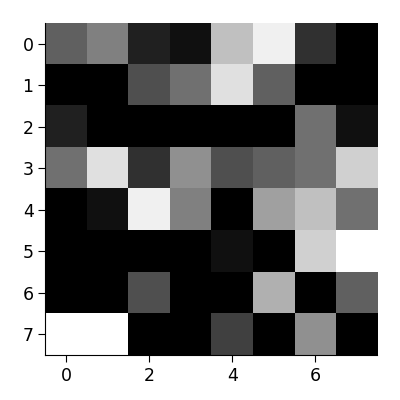

In [5]:
# visualizing the example we see that lower values correspond to darker pixels
# and higher values correspond to lighter values
fig, ax = plt.subplots(figsize=(4,4))
remove_ip_clutter(fig)
ax.imshow(Xs[0].reshape(8,8), cmap='gray')
plt.show()

These input neurons are then connected by synapses to a single output neuron. The activation level of this output neuron is computed as
$$a = \mathbf{Wx} + b$$
Here, $b$ is the (scalar) bias, or baseline activation level of the output neuron, and $\mathbf{W}$ is a matrix of synaptic weights between the input neurons and the single output neuron. (In this case where there is only one output neuron so $\mathbf{W}$ has shape 1x64 so could also be thought of as a row vector.)  

Often to simplify exposition and coding the input $\mathbf{x}$ is augmented to have a feature which is always 1, and then the bias terms can be treated as the weight connecting to this constant valued feature. That is

$$a = \mathbf{Wx}$$

Though now $\mathbf{W}$ has shape 1x65. As before, the probabilistic spiking of this output neuron determines the strike-no-strike behaviour of the organism, specifically:
$$ \Pr \{\text{strike}\} = \sigma(a) $$
$$ \Pr \{\text{no strike}\} = 1 - \sigma(a)$$

Recall that $\sigma(a): \frac{1}{1+e^{-a}} = \frac{e^a}{1+e^a}$ is the standard logistic (sigmoid) function.

The organism recieves a reward of 1 for striking at the right time and a penalty of -1 for striking at the wrong time. It also recieves a reward of zero when not striking, regardless of whether striking would have returned a reward or a penalty. Given this, complete the coding exercise below to write a function that determines the reward recieved for a given sensory input $\mathbf{x}$, the organism's probablistic response to the stimulus, $\Pr \{\text{strike}\} = \sigma(\mathbf{Wx})$, and the resultant outcome of the behaviour given the presence ($y=1$) or absence ($y=0$) of prey. Note that reward depends on three inputs, two $\mathbf{x}$ and $y$ have to do with the state of the environment, and are fully outside of the control of the organism, the other $\mathbf{W}$ determines the organism's response to the environment, and it is this $\mathbf{W}$, that the organism has some control over in that sense that $\mathbf{W}$ is what changes as a result of learning.

In [6]:
################################################################################
# TODO for students: Complete the lines with ... set the appropriate rewards for
# for the evaluations function
raise NotImplementedError("Exercise: Set the reward for different outcomes")
################################################################################

# As a little trick to keep our code cleaner we 'hide' our bias term.
# We to do this by augmenting the features to include a feature that always has the value '1'.
# Then, the 'weight' associated with this feature, which always has a value of '1', effectively serves as the bias term.
# After augmentation there is one extra column of features
Xs_aug = np.hstack([Xs, np.ones((Xs.shape[0],1))])

def np_sigmoid(x):
  x = np.clip(x, -500, 500) #prevent overflow, fine because sigmoid saturates
  return 1 / (1 + np.exp(-x))

def eval_params_stochastic_single(W, x, y, verbose=False, rng=None):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) np.array) sensory input
    y: (outputs(1) np.array) target behavioural output

  Returns:
    R: the reward obtained given the parameters, inputs and targets
  """
  if rng is None:
    rng = np.random.default_rng()
  # activaation
  a = np.dot(W,x)
  # strike probability
  y_hat = np_sigmoid(a)
  # what the organism actually does
  # rng.random is a sample from the uniform distribution on [0,1)
  y_sample = rng.random() < y_hat
  if y_sample == 1: #organism strikes
    if y == 1: #prey is present
      R = ...
    else: # prey is not present
      R = ...
  else: # organism does not strike
    R = ...
  if verbose:
    print(f'Probability of striking: {y_hat}')
    action_string = 'Strike' if y_sample == 1 else 'No Strike'
    print(f'Action taken: {action_string}')
    target_string = 'Strike' if y == 1 else 'No Strike'
    print(f'Correct Action: {target_string}')
    print(f'Reward recieved: {R}')
  else:
    return R

eval_rng = np.random.default_rng(0)
W_test = np.zeros((1,65))
eval_params_stochastic_single(W_test, Xs_aug[0], y1[0], verbose=True, rng=eval_rng)

NotImplementedError: Exercise: Set the reward for different outcomes

In [7]:
# to_remove solution

# As a little trick to keep our code cleaner we 'hide' our bias term.
# We to do this by augmenting the features to include a feature that always has the value '1'.
# Then, the 'weight' associated with this feature, which always has a value of '1', effectively serves as the bias term.
# After augmentation there is one extra column of features
Xs_aug = np.hstack([Xs, np.ones((Xs.shape[0],1))])

def np_sigmoid(x):
  x = np.clip(x, -500, 500) #prevent overflow, fine because sigmoid saturates
  return 1 / (1 + np.exp(-x))

def eval_params_stochastic_single(W, x, y, verbose=False, rng=None):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) np.array) sensory input
    y: (outputs(1) np.array) target behavioural output

  Returns:
    R: the reward obtained given the parameters, inputs and targets
  """
  if rng is None:
    rng = np.random.default_rng()
  # activaation
  a = np.dot(W,x)
  # strike probability
  y_hat = np_sigmoid(a)
  # what the organism actually does
  # rng.random is a sample from the uniform distribution on [0,1)
  y_sample = rng.random() < y_hat
  if y_sample == 1: #organism strikes
    if y == 1: #prey is present
      R = 1
    else: # prey is not present
      R = -1
  else: # organism does not strike
    R = 0
  if verbose:
    print(f'Probability of striking: {y_hat}')
    action_string = 'Strike' if y_sample == 1 else 'No Strike'
    print(f'Action taken: {action_string}')
    target_string = 'Strike' if y == 1 else 'No Strike'
    print(f'Correct Action: {target_string}')
    print(f'Reward recieved: {R}')
  else:
    return R

eval_rng = np.random.default_rng(0)
W_test = np.zeros((1,65))
eval_params_stochastic_single(W_test, Xs_aug[0], y1[0], verbose=True, rng=eval_rng)

Probability of striking: [0.5]
Action taken: No Strike
Correct Action: No Strike
Reward recieved: 0


So that evaluates the reward over a single experience. We can use numpy broadcasting to apply this same reward calculation efficiently to many, even all, the input-out pairs in our data set. We call this **batch** evaluation.

In [ ]:
################################################################################
# TODO for students: Complete the lines with ... to compute the number of
# True Positives, False Positives, True Negative and False Negatives in the batch
raise NotImplementedError("Exercise: Compute the number of different Outcomes")
################################################################################

def eval_params_stochastic_batch(W, x, y, verbose=False, rng=None):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) x batch np.array) sensory input
    y: (outputs(1) x batch np.array) target behavioural output

  Returns:
    R: the reward obtained given the parameters, inputs and targets
  """
  if rng is None:
    rng = np.random.default_rng()
  # activaation
  a = np.dot(W,x) # 1 x batch
  # strike probability
  y_hat = np_sigmoid(a) # 1 x batch
  # what the organism actually does
  # rng.random is a sample from the uniform distribution on [0,1)
  y_sample = rng.random(size=y_hat.shape) < y_hat  # 1 x batch
  R = np.zeros(y_sample.shape)
  did_strike = y_sample == ...
  did_not_strike = y_sample == ...
  should_strike = y == ...
  should_not_strike = y == ...
  TP = np.logical_and(did_strike, should_strike) # True Positive
  FP = np.logical_and(did_strike, should_not_strike) # False Positive
  FN = np.logical_and(did_not_strike, should_strike) # False Negative
  TN = np.logical_and(did_not_strike, should_not_strike) # True Negative
  R[TP] = 1
  R[FP] = -1
  R[FN] = 0
  R[TN] = 0
  TPs = np.sum(TP)
  FPs = np.sum(FP)
  FNs = np.sum(FN)
  TNs = np.sum(TN)
  confusion_matrix = np.array([[TPs, FNs], [FPs, TNs]])
  if verbose:
    table = [["Should Strike", TPs, FNs],
                 ["Shouldn't Strike", FPs, TNs]]
    headers = ["", "Did Strike", "Didn't Strike"]
    print("Confusion_matrix: ")
    print(tabulate(table, headers=headers, tablefmt="grid"))
    print(f'Total Reward: {np.sum(R)}')
    return None
  else:
    return np.sum(R), confusion_matrix

eval_rng = np.random.default_rng(0)
W_test = np.zeros((1,65))
# Xs_aug and y1 are batch x 65 and batch x 1, function wants transpose of this shape
# for broadcasting to work
print('Evaluation 1')
eval_params_stochastic_batch(W_test, Xs_aug.T, y1.T, verbose=True, rng=eval_rng)
print('\nEvaluation 2')
eval_params_stochastic_batch(W_test, Xs_aug.T, y1.T, verbose=True, rng=eval_rng)

In [ ]:
# to_remove solution

# As a little trick to keep our code cleaner we 'hide' our bias term.
# We to do this by augmenting the features to include a feature that always has the value '1'.
# Then, the 'weight' associated with this feature, which always has a value of '1', effectively serves as the bias term.
# After augmentation there is one extra column of features
Xs_aug = np.hstack([Xs, np.ones((Xs.shape[0],1))])

def np_sigmoid(x):
  x = np.clip(x, -500, 500) #prevent overflow, fine because sigmoid saturates
  return 1 / (1 + np.exp(-x))

def eval_params_stochastic_batch(W, x, y, verbose=False, rng=None):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) x batch np.array) sensory input
    y: (outputs(1) x batch np.array) target behavioural output

  Returns:
    R: the reward obtained given the parameters, inputs and targets
  """
  if rng is None:
    rng = np.random.default_rng()
  # activaation
  a = np.dot(W,x) # 1 x batch
  # strike probability
  y_hat = np_sigmoid(a) # 1 x batch
  # what the organism actually does
  # rng.random is a sample from the uniform distribution on [0,1)
  y_sample = rng.random(size=y_hat.shape) < y_hat  # 1 x batch
  R = np.zeros(y_sample.shape)
  did_strike = y_sample == 1
  did_not_strike = y_sample == 0
  should_strike = y == 1
  should_not_strike = y == 0
  TP = np.logical_and(did_strike, should_strike) # True Positive
  FP = np.logical_and(did_strike, should_not_strike) # False Positive
  FN = np.logical_and(did_not_strike, should_strike) # False Negative
  TN = np.logical_and(did_not_strike, should_not_strike) # True Negative
  R[TP] = 1
  R[FP] = -1
  R[FN] = 0
  R[TN] = 0
  TPs = np.sum(TP)
  FPs = np.sum(FP)
  FNs = np.sum(FN)
  TNs = np.sum(TN)
  confusion_matrix = np.array([[TPs, FNs], [FPs, TNs]])
  if verbose:
    table = [["Should Strike", TPs, FNs],
                 ["Shouldn't Strike", FPs, TNs]]
    headers = ["", "Did Strike", "Didn't Strike"]
    print("Confusion_matrix: ")
    print(tabulate(table, headers=headers, tablefmt="grid"))
    print(f'Total Reward: {np.sum(R)}')
    return None
  else:
    return np.sum(R), confusion_matrix

eval_rng = np.random.default_rng(0)
W_test = np.zeros((1,65))
# Xs_aug and y1 are batch x 65 and batch x 1, function wants transpose of this shape
# for broadcasting to work
print('Evaluation 1')
eval_params_stochastic_batch(W_test, Xs_aug.T, y1.T, verbose=True, rng=eval_rng)
print('\nEvaluation 2')
eval_params_stochastic_batch(W_test, Xs_aug.T, y1.T, verbose=True, rng=eval_rng)

Note that the two evaluations give different total rewards, even though the exact same synaptic weights $\mathbf{W}$ are being used, on the exact same batch of inputs $\mathbf{x}$ and prey presence indicators $y$. This is expected given the inherent stochasticity in the organisms behaviour. This stochastic evaluation of the synaptic weights will make things difficult for the perturb-measure-step alogorithm though, because it relies upon precise function evaluations to get good estimates of the rate of improvement in a given direction in parameter space. We can overcome this stochastic evaluation issue though by using our knowledge of how the different probabilities of striking or not determine the expected, or average reward. By directly evaluating expected reward we can recover a precise, deterministic evaluation function.

In [ ]:
def eval_params_expectation_batch(W, x, y, verbose=False):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) x batch np.array) sensory input
    y: (outputs(1) x batch np.array) target behavioural output

  Returns:
    R_exp: the expected reward obtained over the batch given the parameters, inputs and targets
  """
  # activaation
  a = np.dot(W,x) # 1 x batch
  # strike probability
  y_hat = np_sigmoid(a) # 1 x batch
  # Expected true positives (TPs) and false positives (FPs)
  TPs = np.sum(y_hat * y)  # Sum of strike probabilities where true label is 1
  FPs = np.sum(y_hat * (1 - y))  # Sum of strike probabilities where true label is 0
  # Expected false negatives (FN_e) and true negatives (TN_e)
  FNs = np.sum((1 - y_hat) * y)  # Sum of no strike probabilities where true label is 1
  TNs = np.sum((1 - y_hat) * (1 - y))  # Sum of no strike probabilities where true label is 0
  R_exp = 1 * TPs + 0 * FNs + -1 * FPs + 0 * TNs
  confusion_matrix = np.array([[TPs, FNs], [FPs, TNs]])
  if verbose:
    table = [["Should Strike", TPs, FNs],
             ["Shouldn't Strike", FPs, TNs]]
    headers = ["", "Did Strike", "Didn't Strike"]
    print("Confusion_matrix: ")
    print(tabulate(table, headers=headers, tablefmt="grid"))
    print(f'Total Reward: {R_exp}')
    return None
  else:
    return R_exp, confusion_matrix

W_test = np.zeros((1,65))
# Xs_aug and y1 are batch x 65 and batch x 1, function wants transpose of this shape
# for broadcasting to work
print('Evaluation 1')
eval_params_expectation_batch(W_test, Xs_aug.T, y1.T, verbose=True)
print('\nEvaluation 2')
eval_params_expectation_batch(W_test, Xs_aug.T, y1.T, verbose=True)

Note that as hoped, the evaluation of parameters using expected reward, is consistent, as it should be. As a sanity check we see that the distribution of stochastic evaluations is roughly symmetric, and centered around this expectation, with the average of many such stochastic evaluations becoming close to our calculated expected value.

In [ ]:
# @markdown **Run this cell** to visualize the distribution of stochastic parameter evaluation, relative to the expectation.
def eval_params_expectation_batch(W, x, y, verbose=False):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) x batch np.array) sensory input
    y: (outputs(1) x batch np.array) target behavioural output

  Returns:
    R_exp: the expected reward obtained over the batch given the parameters, inputs and targets
  """
  # activaation
  a = np.dot(W,x) # 1 x batch
  # strike probability
  y_hat = np_sigmoid(a) # 1 x batch
  # Expected true positives (TPs) and false positives (FPs)
  TPs = np.sum(y_hat * y)  # Sum of strike probabilities where true label is 1
  FPs = np.sum(y_hat * (1 - y))  # Sum of strike probabilities where true label is 0
  # Expected false negatives (FN_e) and true negatives (TN_e)
  FNs = np.sum((1 - y_hat) * y)  # Sum of no strike probabilities where true label is 1
  TNs = np.sum((1 - y_hat) * (1 - y))  # Sum of no strike probabilities where true label is 0
  R_exp = 1 * TPs + 0 * FNs + -1 * FPs + 0 * TNs
  confusion_matrix = np.array([[TPs, FNs], [FPs, TNs]])
  if verbose:
    table = [["Should Strike", TPs, FNs],
             ["Shouldn't Strike", FPs, TNs]]
    headers = ["", "Did Strike", "Didn't Strike"]
    print("Confusion_matrix: ")
    print(tabulate(table, headers=headers, tablefmt="grid"))
    print(f'Total Reward: {R_exp}')
    return None
  else:
    return R_exp, confusion_matrix

def eval_params_stochastic_batch(W, x, y, verbose=False, rng=None):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) x batch np.array) sensory input
    y: (outputs(1) x batch np.array) target behavioural output

  Returns:
    R: the reward obtained given the parameters, inputs and targets
  """
  if rng is None:
    rng = np.random.default_rng()
  # activaation
  a = np.dot(W,x) # 1 x batch
  # strike probability
  y_hat = np_sigmoid(a) # 1 x batch
  # what the organism actually does
  # rng.random is a sample from the uniform distribution on [0,1)
  y_sample = rng.random(size=y_hat.shape) < y_hat  # 1 x batch
  R = np.zeros(y_sample.shape)
  did_strike = y_sample == 1
  did_not_strike = y_sample == 0
  should_strike = y == 1
  should_not_strike = y == 0
  TP = np.logical_and(did_strike, should_strike) # True Positive
  FP = np.logical_and(did_strike, should_not_strike) # False Positive
  FN = np.logical_and(did_not_strike, should_strike) # False Negative
  TN = np.logical_and(did_not_strike, should_not_strike) # True Negative
  R[TP] = 1
  R[FP] = -1
  R[FN] = 0
  R[TN] = 0
  TPs = np.sum(TP)
  FPs = np.sum(FP)
  FNs = np.sum(FN)
  TNs = np.sum(TN)
  confusion_matrix = np.array([[TPs, FNs], [FPs, TNs]])
  if verbose:
    table = [["Should Strike", TPs, FNs],
                 ["Shouldn't Strike", FPs, TNs]]
    headers = ["", "Did Strike", "Didn't Strike"]
    print("Confusion_matrix: ")
    print(tabulate(table, headers=headers, tablefmt="grid"))
    print(f'Total Reward: {np.sum(R)}')
    return None
  else:
    return np.sum(R), confusion_matrix

W_test = np.zeros((1,65))
exp_reward, _ = eval_params_expectation_batch(W_test, Xs_aug.T, y1.T, verbose=False)

# Generate stochastic rewards
stochastic_rewards = []
for _ in range(500):  # Simulate 100 times to create a distribution
  r, _ = eval_params_stochastic_batch(W_test, Xs_aug.T, y1.T, verbose=False)
  stochastic_rewards.append(r)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
remove_ip_clutter(fig)
ax.hist(stochastic_rewards, bins=20, alpha=0.75, label='Stochastic Evaluations')
ax.axvline(x=exp_reward, color='r', linestyle='dashed', linewidth=2, label=f'Expected Reward: {exp_reward}')
ax.set_title('Comparison of Stochastic Evaluations and Expected Reward')
ax.set_xlabel('Reward')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

As yet another sanity check we calculate the expected reward when striking and not striking with equal probability, in all circumstances, which is what we expect from a $\mathbf{W}$ of all zeros.

In [ ]:
# There are this many cases where striking is good
np.sum(y1 == 1)

In [ ]:
# And this many cases where striking is bad
np.sum(y1 == 0)

In [ ]:
# W = 0 should strike half the time no matter what,
# in which case would expect a reward of
(2829 - 2791) / 2

That all checks out, so now that we have some confidence in our evaluation function let's see if perturb-measure-step is able to find a good set of values for $\mathbf{W}$ using the batch expected value version of parameter evaluation. Run the training loop. The process will take a minute or two to complete, while its running inspect the code and see if it makes sense to you.

In [ ]:
# @title Stochastic-Perturb-Measure-Step Training Loop
learn_rng = np.random.default_rng(0)
num_steps = 60000
step_scale = 0.002
dimensional_scale_factor = np.sqrt(65)
perturbation_scale = 0.0001 # std of gaussian test perturbations
W_init = np.zeros((1,65))
W = W_init
start_time = time.time()
for step in range(num_steps):
  R_current, _ = eval_params_expectation_batch(W, Xs_aug.T, y1.T)
  raw_test_perturb = learn_rng.standard_normal(size=(1,65))
  unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb.flatten())
  test_perturbation = unit_test_perturb * perturbation_scale
  R_test, _ = eval_params_expectation_batch(W + test_perturbation, Xs_aug.T, y1.T)
  directional_grad_est = (R_test - R_current) / perturbation_scale
  W += step_scale * dimensional_scale_factor * directional_grad_est * unit_test_perturb

  if step == 0 or (step + 1) % 3000 == 0:
    elapsed_time = time.time() - start_time
    print(f'Step {step + 1}/{num_steps} completed | Expected Total Batch Reward: {R_current:.6f} | Time elapsed: {elapsed_time:.2f} seconds')
eval_params_expectation_batch(W, Xs_aug.T, y1.T, verbose=True)

The best possible score is 2829, and perturb measure step is able to discover network parameters that achieve a score of roughly 2500, in 60,000 steps. This is pretty good, better than we the humans were able to do in terms of figuring out the pattern, before we got bored of the problem in a few minutes. This is all well and good as an optimization exercise, but if we want to connect this form of optimization back to our inspirational cartoon of neural behaviour as a kind of learning, there are a few issues. Three major issues stand out as ways in which the perturb-measure-step training loop above deviates from a process that is simple and local enough to serve as plausible (even if very abstract) model of a physiological syanptic plasticity processes. These key issues are:
1. The organism's striking behaviour is stochastic but expected reward outcomes, not actual obtained reward outcomes are used to drive updates to the synaptic parameters $\mathbf{W}$.
2. The evaluation of a given synaptic configuration is based on performance over all of the 5620 of distcint input-outpur pairs (sensory-pattern, prey-presence) in the data set that defines the "environment" of this learning problem. Physiologically viable would be evaluations over a single, or at least relatively few, stimulus-response-reward episodes.
3. Evaluations are performed in seperate perturbation and non-perturbation modes in the training loop above. A single mode of evaluation that operated fully "online" and in congunction with the ongoing generation of behaviour is more simple and easy to imagine physiological implementations of.

There are of course many other ways in which the this cartoon learning system deviates from what might plausibly be implemented in an actual simple neural system, but these have more to do with the abstractness of the model, and can concievibly be remedied with careful choices about how to make the model more concrete so as to map nicely onto measurable phyiological features of neural plasticity. In contrast, for the critical points oulined above, it is difficult to imagine how any of these key issues can be overcome physiologically, without invoking additional complex neural circuits and processes, the orgin of which also need to be explained. So for this sequence and the next we focus on addressing these core issues, different-modes, batch versus single experience based reward, and expected versus actual recieved (stochastic) reward.

In the rest of this sequence we will adapt the base perturb-measure-step update rule to address each of these three issues. But first let's just get a bit of a sense of how these issues impinge upon the fantasy of using perturb-measure-step as an algorithm that might feasibly be used by a living organism to update the connection strengths of this simple network determining behaviour in response to stimulus. In each interation in the vanilla perturb-measure-step training loop implemented above the organism first evaluates its current parameters based on the expected reward over all 5620 possible experiences. It then perturbs its synaptic parameters and evaluates its performance again on all 5620 experiences, these two evaluations are compared to determine $\Delta R$ and this together with the pertrubations $\Delta W_i$ determine the synaptic connections update according to

$$ W_i' = W_i + s \ \Delta W_i \ \Delta R $$
where
$$\Delta R = R(\mathbf{W} + \Delta \mathbf{W}) - R(\mathbf{W})$$
and $R(\mathbf{W})$ is our reward/evaluation function.
Note that $s$ needs to be carefully choosen to account both for the average size of the perturbation $\| \mathbf{W} \|$, the appropriately level of scaling given the expected alignment of a random perturbation with the gradient given the dimensionality of $\mathbf{W}$, and the relative scale of the gradient. While this is can be a challenge in practical applications, the "dialing-in" of meta-parameters of learning algorithms is something that we expect evolution to be quite good at.

This process would require the organism somehow integrate all of the reward outcomes of all 5620 experiences, remember this aggregated outcome, then integrate up the reward outcomes of another 5620 experiences accumulated while in 'perturbation' mode, and then update its parameters based on a comparison of the remembered and the recently accumlated aggregate reward outcome. This all seems a bit complicated, and difficult to implement with simple, primarily local, synaptic plasticity mechanisms. What we would like intead is a version of perturb-measure-step that updates its synaptic weights as a result of every reward experience, doesn't rely on an expected reward calculation, and that does not have a seperate perturbation mode.

Removing the seperate perturbation mode is perhaps the easiest issue to address so we take this on first.

# 2.1.4.2 Stochastic-Step-Measure-Step

One simple way to avoid a seperate perturbation evaluation is to simply compress the perturbation and the update into a single step. We call such an update method step-measure-step as contrasted with perturb measure step. This new update rule looks like this.



$$\ W_{i}(t+1)= W_i(t) + s \ (W_i(t) - W_i(t-1)) \ \ R(\mathbf{W}(t)) - R(\mathbf{W}(t-1)) + \xi_{i}(t)$$

Previously we used $\Delta$ to denote the perturbation and did not directly reference the parameter update. Because now we are combining the perturbation and the parameter update we use $\Delta$ to denote this combined change, that is
$$ \ W_{i}(t+1) - W_i(t) = \Delta W_i(t) $$

Then the above simplifies

$$ \Delta W_i(t) = s \ \Delta W_i(t-1) \ \Delta R(t) + \xi_i(t) $$
Here $\Delta R(t) = R(\mathbf{W}(t)) - R(\mathbf{W}(t-1))$

Let's see if


In [ ]:
# @title Stochastic-Step-Measure-Step Training Loop
learn_rng = np.random.default_rng(0)
num_steps = 100000
init_step_scale = 0.003 * np.sqrt(65)
init_noise_scale = 0.0005
total_scale = 1.0
#later_step_scale = 0.002 * np.sqrt(65)
#later_noise_scale = 0.0001
W_init = np.zeros((1,65))
W = W_init
delta_W = np.zeros((1,65))
R, _ = eval_params_expectation_batch(W, Xs_aug.T, y1.T)
start_time = time.time()
step_scale = init_step_scale
noise_scale = init_noise_scale
for step in range(num_steps):
  R_old = R
  R, _ = eval_params_expectation_batch(W, Xs_aug.T, y1.T)
  delta_R = R - R_old
  delta_W_noise = learn_rng.normal(0, noise_scale, size=(1,65))
  delta_W = total_scale * (step_scale * delta_W * delta_R + delta_W_noise)
  W += delta_W

  if step == 0 or (step + 1) % 10000 == 0:
    elapsed_time = time.time() - start_time
    #print(f'Delta R: {delta_R}')
    #print(f'Delta W: {delta_W}')
    print(f'Step {step + 1}/{num_steps} completed | Total Expected Reward: {R:.6f} | Time elapsed: {elapsed_time:.2f} seconds')
    #if step > 40000:
    #  step_scale = later_step_scale
    #  noise_scale = later_noise_scale
eval_params_expectation_batch(W, Xs_aug.T, y1.T, verbose=True)

So this trick of smushing the perturbation and the update into a single step seems to work okay, though not as well as doing the very careful perturbation, but it shows that much of the correct pattern response to stimulus can be discovered through this mode. This particular idea for smushing together the perturbation and the update was is known as ALOPEX (an acronym from "ALgorithms Of Pattern EXtraction",  first proposed by Tzanakou and Harth in 1974.) This is one way of not having a seperate perturbation and non-perturbation mode. There are other ways, such as leveraging the stochasticity of relative spike timings (ref seung), and using reward signals directly (or above some anticipated baseline) which we will discuss these later. For now, it is enough to know that this issue can be mitigated, though with some apparrent cost to overall performance (relative to perturb-measure-step). Let's move on to the next issue.

# 2.1.4.3 Full-Batch versus Mini-Batch Perturb-Measure-Step

Another issue in terms of physiological viability was parameter evaluation based on performance across all possible experiences. In a simple model of learning and synaptic plasticity, we would like learning to be driven by the outcomes of a single stimulus-response-reward experience.

This relates to an important idea in machine learning. The idea of the mini-batch. Even though we are ulitmately interested is the performance of the parameters over all of the input-target pairs in the data set, given how computers operate, it is typically possible to generate a sample evaluation based on a small random sample of the input-target pairs in the data set. Such a samlpe is called a mini-batch of the data. (As contrasted with the entire data-set which is called a full-batch or just batch). Evaluations on these mini-batches provides an estimate of the desired full-batch evaluation. In the extreme case a mini-batch can consist of a single input-output pair. In ML the idea of using mini-batches developed in the context of Gradient Descent optimization (which we haven't covered yet). So even though the mini-batch idea applies to all kinds of optimzation processes, for historical reasons,  learning with mini-batches of size 1 is called "Stochastic Gradient Descent", and learning with mini-batches of size greater than 1 but less than the full batch is called "Mini-Batch Stochastic Gradient Descent", and learning with the full batch is just called Gradient Descent. In practical ML settings, whenever the data-set becomes sufficiently large, mini-batches are almost always used, as they allow for the most efficient use of computational resources. Here we explicitly seperate the mini-batch idea from Gradient Descent, and so use the terms full-batch, mini-batch, and singleton based learning and evaluations. Let's see what having a mini-batch of different sizes does to our learning rates. For now we test out this mini-batch idea on perturb-measure-step.

In [8]:
# @title Mini-Batch(10) Stochastic-Perturb-Measure-Step Training Loop
learn_rng = np.random.default_rng(0)
step_scale = 0.002
mini_batch_size = 10
num_epochs = 400
dimensional_scale_factor = np.sqrt(65)
perturbation_scale = 0.0001 # std of gaussian test perturbations
W_init = np.zeros((1,65))
W = W_init
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for epoch in range(num_epochs):
  np.random.shuffle(indices)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_Xs = Xs_aug[batch_indices].T
    batch_y1 = y1[batch_indices].T
    R_current, _ = eval_params_expectation_batch(W, batch_Xs, batch_y1)
    raw_test_perturb = learn_rng.standard_normal(size=(1,65))
    unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb.flatten())
    test_perturbation = unit_test_perturb * perturbation_scale
    R_test, _ = eval_params_expectation_batch(W + test_perturbation, batch_Xs, batch_y1)
    directional_grad_est = (R_test - R_current) / perturbation_scale
    W += step_scale * dimensional_scale_factor * directional_grad_est * unit_test_perturb

  if epoch == 0 or (epoch + 1) % 20 == 0:
    total_expected_reward, _ = eval_params_expectation_batch(W, Xs_aug.T, y1.T)
    elapsed_time = time.time() - start_time
    print(f'Epoch {epoch + 1}/{num_epochs} completed | Expected Total Batch Reward: {total_expected_reward:.6f} | Time elapsed: {elapsed_time:.2f} seconds')
eval_params_expectation_batch(W, Xs_aug.T, y1.T, verbose=True)

NameError: name 'eval_params_expectation_batch' is not defined

So with a mini-batch of size 10, this works really quite well, basically just as well as evaluating the parameters on the entire experience, what about when we scale down to the extreme case of a mini-batch of size 1?

In [ ]:
# @title Singleton Stochastic-Perturb-Measure-Step Training Loop
learn_rng = np.random.default_rng(0)
step_scale = 0.002
mini_batch_size = 1
num_epochs = 80
dimensional_scale_factor = np.sqrt(65)
perturbation_scale = 0.0001 # std of gaussian test perturbations
W_init = np.zeros((1,65))
W = W_init
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for epoch in range(num_epochs):
  np.random.shuffle(indices)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_Xs = Xs_aug[batch_indices].T
    batch_y1 = y1[batch_indices].T
    R_current, _ = eval_params_expectation_batch(W, batch_Xs, batch_y1)
    raw_test_perturb = learn_rng.standard_normal(size=(1,65))
    unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb.flatten())
    test_perturbation = unit_test_perturb * perturbation_scale
    R_test, _ = eval_params_expectation_batch(W + test_perturbation, batch_Xs, batch_y1)
    directional_grad_est = (R_test - R_current) / perturbation_scale
    W += step_scale * dimensional_scale_factor * directional_grad_est * unit_test_perturb

  if epoch == 0 or (epoch + 1) % 5 == 0:
    total_expected_reward, _ = eval_params_expectation_batch(W, Xs_aug.T, y1.T)
    elapsed_time = time.time() - start_time
    print(f'Epoch {epoch + 1}/{num_epochs} completed | Expected Total Batch Reward: {total_expected_reward:.6f} | Time elapsed: {elapsed_time:.2f} seconds')
eval_params_expectation_batch(W, Xs_aug.T, y1.T, verbose=True)

So learning from a single experience using perturb-measure-step doesn't appear to be a problem at all. If anything it leads to faster (in terms of computational time) learning, since evaluations on a single (or small mini-batch of) input-output pair(s) are much quicker to compute than evaluations of the parameters based on the entirety of the avialble data-set.

Now, unfortunately, the smushing together of the update step and the perturbation step, does not mix well with the mini-batch idea. The key issue here, is that in the mini-batch training loops above **the same** mini-batch was used to evaluate both the base parameters and the perturbed parameters alowing for a precise estimate of the rate of improvement in the direction of the test perturbation. If two **different** mini-batches are used to estimate the reward at two different points in the parameter space (as happens in when we try to use step-measure-step with mini-batches), the noise introduced by using different mini-batches makes the estimate the degree of improvement between the two points much noisier. For many problems this degree of noise is such that learning becomes intractably slow.

In [ ]:
# @title Mini-Batch(20) Step-Measure-Step Training Loop
learn_rng = np.random.default_rng(0)
step_scale = 0.003 * np.sqrt(65)
noise_scale = 0.0005
total_scale = 0.1
mini_batch_size = 20
num_epochs = 200
W_init = np.zeros((1,65))
W = W_init
delta_W = np.zeros((1,65))
R, _ = eval_params_expectation_batch(W, Xs_aug.T, y1.T)
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for epoch in range(num_epochs):
  np.random.shuffle(indices)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_Xs = Xs_aug[batch_indices].T
    batch_y1 = y1[batch_indices].T
    R_old = R
    R, _ = eval_params_expectation_batch(W, batch_Xs, batch_y1)
    delta_R = R - R_old
    delta_W_noise = learn_rng.normal(0, noise_scale, size=(1,65))
    delta_W = total_scale * (step_scale * delta_W * delta_R + delta_W_noise)
    W += delta_W

  if epoch == 0 or (epoch + 1) % 5 == 0:
    total_expected_reward, _ = eval_params_expectation_batch(W, Xs_aug.T, y1.T)
    elapsed_time = time.time() - start_time
    print(f'Epoch {epoch + 1}/{num_epochs} completed | Expected Total Batch Reward: {total_expected_reward:.6f} | Time elapsed: {elapsed_time:.2f} seconds')
eval_params_expectation_batch(W, Xs_aug.T, y1.T, verbose=True)

In [ ]:
def train_and_evaluate(step_scale, noise_scale):
  step_scale = step_scale * np.sqrt(65)
  num_steps = 50000
  W = np.zeros((1, 65))
  delta_W = np.zeros((1,65))
  R, _ = eval_params_expectation_batch(W, Xs_aug.T, y1.T)
  for step in range(num_steps):
    R_old = R
    R, _ = eval_params_expectation_batch(W, Xs_aug.T, y1.T)
    delta_R = R - R_old
    delta_W_noise = learn_rng.normal(0, noise_scale, size=(1,65))
    delta_W = step_scale * delta_W * delta_R + delta_W_noise
    W += delta_W
  R, _ = eval_params_expectation_batch(W, Xs_aug.T, y1.T)
  return R  # or another performance metric

In [ ]:
results = []
for step_scale in [0.003, 0.002, 0.001]:
  for noise_scale in [0.002, 0.001, 0.0005,]:
    print(f'Step Scale: {step_scale}, Noise Scale: {noise_scale}')
    result = train_and_evaluate(step_scale, noise_scale)
    print(result)
    results.append((step_scale, noise_scale, result))

# 2.1.3.5 Perturb-Measure-Step at the Synaptic Level

So our update rule for perturb-measure-step can be written in compact mathematical notation as

$$ \mathbf{W}' = \mathbf{W} + s \Delta\mathbf{W}\Delta R $$

This is saying that the new parameters are equal to the old parameters, shifted in the direction of some random perturbation, proportional to the rate of improvement in that random direction. So each element of the perturbation $\Delta \mathbf{W}$, $\Delta W_i$, is normally distributed with mean zero and standard deviation equal to the perturbation scale. The rate of improvement in that direction is given by

$$\Delta R = \frac{f(\mathbf{W}_t + \Delta \mathbf{W}) - f(\mathbf{W}_t)}{\| \Delta \mathbf{W}\|}$$

This is all well and good, but what does this translate to in terms of an update rule for individual synapses?

$$ W_i' = W_i + s \Delta W_i \Delta R $$

From this rule it may be clear, that sometimes this learning rule will cause individual synaptic weights to shift in bad direction, since $\Delta R$ is based on an evaluation of a shift in all the weights in our stochastic-perturb-measure-step. Note though, that in our original perturb-measure-step we only to perturbed one weight at a time, and systematically iterated through all the weights. From a physiological point of view this kind of systematic, iterative perturbation of weights seems basically impossible to coordinate, whereas small random perturbations to the effective synaptic weights is highly plausible through a number of different physiological mechanisms, several of which already have clear empirical support. Similarly, the presence of globally acting "Reward Signals" also has clear empirical evidence for some networks in the brain. From the perspective physiological mechanisms alone, this kind of synaptic update rule is highly plausible.  

Now whenever we look at the performance of a model, we have to ask ourselves, is it not getting better because our training algorithm can't make the model any better, or is the *expressivity* of the model maxed out, and given the structural limitations (basically the number of parameters in our model and how they combine to produce outputs that are contingent on inputs). Could such a model ever do any better? It turns out that this is roughly about as good as can be expected with a network as simple as this. The next question then is, can we do better with a more complex network? Let's see

# 2.1.3.4 Is Solving High Dimensional Optimization Problem Necissary for Adaptive Behaviour? Hard Yes.

One reason for having a large, flexible brain is to produce complex behaviour that is contingent on the state of the world in complex ways. Our simple strike-no-strike network, consisted of a single layer of synaptic connections between the sensory inputs and the motor outputs. In a shallow network structure like this a sensory input either directly inhibits or promotes the striking behaviour, there is no possibility for the a sensory input to promote striking in some sensory contexts, but inhibit it in others. This is a deficincy. Context is important, loud thumping and roaring noises at a concert means the band is good, similar noises when camping in the wilderness means a large animal is nearby. A shallow network does not allow for such context dependence. However, by simply adding an additional layer to the network, consisting of some intermediate (hidden) neurons between the inputs and the output, limited forms of context dependent inhibition and promotion of striking are possible.

One thing that could be holding back performance on this discrimination problem is that our algorithms are not capable of finding the optimal parameters for the given model, but... we don't really think that is the case here. Another possibility is that our simple sensory-behaviour circuit is not flexible or complex enough to fully discriminate between the two types of input. There is good reason to think that this might be the case. Our current sensory-behavioural circuit is effectively equivalent to logistic regression, i.e. each feature can either inhibit or potentiate striking behaviour to varying degrees, but there is no possibility for conditional interaction between features. By 'conditional interaction,' we mean a scenario where, for instance, feature 1 typically inhibits the behavior, except when feature 2 is positive, under which condition feature 1 becomes potentiating. These kinds of feature interactions are impossible in the current model. One way to allow for such interactions is to augment the base set of features with composite features, e.g. incorporate all the pairwise products of the existing feature set, so that instead of 65 features (bias included) we have $(65^2 - 1) = 4224$ features to work with. This could work, but what if we want something that depends on the interaction of more than 2 features, adding higher order polynomial terms will quickly make the problem intractable (Reference appendix section on why hidden layers not polynomials if we do that). If we had some mechanistically grounded understanding or hypothesis about the relationship between the features and label could might be able to cherry pick some small subset of higher order interaction terms, but the ML/supervised learning framework is in large part about automating the feature selection processes based on the data alone. In turns out that instead of resorting the regression on polynomial terms to capture feature interactions, there is a much more compact and expressive way of allowing for feature interactions. The idea is to allow for feature interactions to emerge as needed in a 'hidden' computational layer of our highly abstracted neurons.

Our new strike-no-strike network with 1 hidden layer is structured as follows

As before $\mathbf{x}$ is the raw sensory input (vector) in a given episode and each element of $\mathbf{x}$ corresponds to the activation level and firing rate of a single photosensitive neuron.
These input neurons are then connected by synapses to a 'hidden layer' of intermediate computational neurons, say 10 of them. The activation level of these hidden layer neurons is computed as
$$\mathbf{h} = \sigma(\mathbf{W}_{in} \cdot \mathbf{x})$$
Now $\mathbf{W}_{in}$ is a matrix of synaptic weights between the input neurons and the hidden layer neurons, and $\cdot$ denotes standard matrix vector multiplication. (In this case $\mathbf{W}$ has shape $10 \times 65$. Each the values in the $i^{th}$ row of $\mathbf{W}_{in}$ given the sign and strength of the connections coming into the $i^{th}$ element of $h$ and similarly each value in the $j^{th}$ column of $\mathbf{W}_{in}$ corresponds to connection strengths coming out of the $j^{th}$ sensory input neuron.)  We still us $\sigma$ to represent the standard logistic sigmoid function, but in these case applied elementwise the vector output of the product $\mathbf{W}_{in} \cdot \mathbf{x}$. Then much as before our striking probability is computed as
$$y = \mathbf{W}_{out} \cdot \mathbf{h}$$
and
$$ \Pr \{\text{strike}\} = \sigma(y) $$
$$ \Pr \{\text{no strike}\} = 1 - \sigma(y)$$
Here $\mathbf{W}_{out}$ has shape $1  \times 10$.


We will need to write a new eval params function for this new model, let's do it.

In [ ]:
def eval_params_hidden(W_in, W_out, x, y, verbose=False):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W_in: (hidden-neurons(20) x inputs(65) np.array)
           weights between sensory neurons and hidden layer neurons
    W_out: (output(1) x hidden-neurons(20) np.array)
           weights between hidden layer neurons and output
    x: (input(64) x batch np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (outputs(1) x batch np.array) target behavioural output
       (can be a single target, mini-batch of targets, or whole batch),
       needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  h = np_sigmoid(np.dot(W_in,x)) # hidden x batch
  y_hat = np_sigmoid(np.dot(W_out,h)) # 1 x batch
  y_score = np.copy(y)
  y_score[y_score == 0] = -1
  batch_expected_reward = y_score * y_hat
  R_bar = np.sum(batch_expected_reward)
  if verbose:
    # Expected true positives (TP_e) and false positives (FP_e)
    TP_e = np.sum(y_hat * y)  # Probabilities where true label is 1
    FP_e = np.sum(y_hat * (1 - y))  # Probabilities where true label is 0
    # Expected false negatives (FN_e) and true negatives (TN_e)
    FN_e = np.sum((1 - y_hat) * y)  # (1 - probabilities) where true label is 1
    TN_e = np.sum((1 - y_hat) * (1 - y))  # (1 - probabilities) where true label is 0
    confusion_matrix = np.array([[TP_e, FN_e], [FP_e, TN_e]])
    table = [["Should Strike", TP_e, FN_e],
                 ["Shouldn't Strike", FP_e, TN_e]]
    headers = ["", "Did Strike", "Didn't Strike"]
    print("Expected Confusion_matrix: ")
    print(tabulate(table, headers=headers, tablefmt="grid"))
    print(f'Expected reward: {R_bar}')
    return None
  else:
    return R_bar


We've got a more complicated circuit with more parameters, how much longer does it take us to evaluate this circuit compared to our previous one?

In [ ]:
W = np.zeros((1,65))
%timeit eval_params_aug(W, Xs_aug.T, y1.T)

In [ ]:
W_in = np.zeros((10,65))
W_out = np.zeros((1,10))
%timeit eval_params_hidden(W_in, W_out, Xs_aug.T, y1.T)

Roughly 5x longer per function evaluation, which means not only will we likely need more iterations of our algorithm because it is harder to find good parameters in high dimensions (we have 660 parameters now, which is a lot more than 65), but also each of those steps will take longer to process because function evaluations are also more costly. It will all be worth it if we can get better final performance though.

In [ ]:
# @title 10 Hidden Units - Perturb-Measure-Step Training Loop
learn_rng = np.random.default_rng(0)
num_steps = 30000
step_scale = 0.025
perturbation_scale = 0.0001 # std of gaussian test perturbations
num_hidden_units = 10
# initializing both layers as zero leads to some issues, so we
# use a Xavier/Glorot random initialization scheme
in_init = np.sqrt(6 / (65 + num_hidden_units))
W_in_init = learn_rng.uniform(-in_init, in_init, size=(num_hidden_units, 65))
out_init = np.sqrt(6 / (10 + 1))
W_out_init = learn_rng.uniform(-out_init, out_init, size=(1, num_hidden_units))
flat_params = np.concatenate((W_in_init.flatten(), W_out_init.flatten()))
dimensional_scale_factor = np.sqrt(len(flat_params))
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for step in range(num_steps):
  W_in, W_out = np.split(flat_params, [650])
  W_in = W_in.reshape((10,65))
  W_out = W_out.reshape((1,10))
  R_current = eval_params_hidden(W_in, W_out, Xs_aug.T, y1.T)
  raw_param_perturb = learn_rng.standard_normal(size=len(flat_params))
  unit_param_perturb = raw_param_perturb / np.linalg.norm(raw_param_perturb.flatten())
  test_perturbation = unit_param_perturb * perturbation_scale
  perturbed_flat_params = flat_params + test_perturbation
  W_in_test, W_out_test = np.split(perturbed_flat_params, [650])
  W_in_test = W_in_test.reshape((10,65))
  W_out_test = W_out_test.reshape((1,10))
  R_test = eval_params_hidden(W_in_test, W_out_test, Xs_aug.T, y1.T)
  directional_grad_est = (R_test - R_current) / perturbation_scale
  flat_params += step_scale * dimensional_scale_factor * directional_grad_est * unit_param_perturb

  if step == 0 or (step + 1) % 1000 == 0:
    elapsed_time = time.time() - start_time
    print(f'Step {step + 1}/{num_steps} completed | Current Total Reward: {R_current:.6f} | Time elapsed: {elapsed_time:.2f} seconds')
W_in, W_out = np.split(flat_params, [650])
W_in = W_in.reshape((10,65))
W_out = W_out.reshape((1,10))
eval_params_hidden(W_in, W_out, Xs_aug.T, y1.T, verbose=True)


So this new, more complex circuit is great. We're much closer to the theoretical maximum performance of 2829, maybe with a few more hidden units, and a little longer training time we could have perfect discrimination. Let's see what happens when we go up to 20 hidden units. As a heads up this is going to take awhile (about 3 minutes) so you should read ahead while waiting for this training loop to complete

In [ ]:
# @title 20 Hidden Units - Perturb-Measure-Step Training Loop
learn_rng = np.random.default_rng(0)
num_steps = 10000
step_scale = 0.025
perturbation_scale = 0.0001 # std of gaussian test perturbations
num_hidden_units = 20
# initializing both layers as zero leads to some issues, so we
# use a Xavier/Glorot random initialization scheme
in_init = np.sqrt(6 / (65 + num_hidden_units))
W_in_init = learn_rng.uniform(-in_init, in_init, size=(num_hidden_units, 65))
out_init = np.sqrt(6 / (num_hidden_units + 1))
W_out_init = learn_rng.uniform(-out_init, out_init, size=(1, num_hidden_units))
flat_params = np.concatenate((W_in_init.flatten(), W_out_init.flatten()))
dimensional_scale_factor = np.sqrt(len(flat_params))
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for step in range(num_steps):
  W_in, W_out = np.split(flat_params, [num_hidden_units*65])
  W_in = W_in.reshape((num_hidden_units,65))
  W_out = W_out.reshape((1,num_hidden_units))
  R_current = eval_params_hidden(W_in, W_out, Xs_aug.T, y1.T)
  raw_param_perturb = learn_rng.standard_normal(size=len(flat_params))
  unit_param_perturb = raw_param_perturb / np.linalg.norm(raw_param_perturb.flatten())
  test_perturbation = unit_param_perturb * perturbation_scale
  perturbed_flat_params = flat_params + test_perturbation
  W_in_test, W_out_test = np.split(perturbed_flat_params, [num_hidden_units*65])
  W_in_test = W_in_test.reshape((num_hidden_units,65))
  W_out_test = W_out_test.reshape((1,num_hidden_units))
  R_test = eval_params_hidden(W_in_test, W_out_test, Xs_aug.T, y1.T)
  directional_grad_est = (R_test - R_current) / perturbation_scale
  flat_params += step_scale * dimensional_scale_factor * directional_grad_est * unit_param_perturb

  if step == 0 or (step + 1) % 500 == 0:
    elapsed_time = time.time() - start_time
    print(f'Step {step + 1}/{num_steps} completed | Current Total Reward: {R_current:.6f} | Time elapsed: {elapsed_time:.2f} seconds')
W_in, W_out = np.split(flat_params, [num_hidden_units*65])
W_in = W_in.reshape((num_hidden_units,65))
W_out = W_out.reshape((1,num_hidden_units))
eval_params_hidden(W_in, W_out, Xs_aug.T, y1.T, verbose=True)


This more complex circuit gets us even closer to the theoretical maximum performance of 2829, but it's taking longer to get there. This is a consequence of both, the function evaluations required at each step being slower (for the more complex function) and because more iterations are needed to effectively search the higher dimensional space for a good configuration of $\mathbf{W}_{in}$ and $\mathbf{W}_{out}$. With even more hidden units and more time we can likely learn perfect discrimination, but it will take even longer (more than 3 minutes!).

Although the toy neural circuit models in this sequence are a far cry from actual neural circuits, they still provide insight into possible mechanisms of synaptic plasticity the brain. We can imagine a scenario where synaptic strengths between neurons in a circuit undergo small, transient perturbations. The brain might integrate and compare the performance of these perturbations over a learning episode (for example, a day) to previous performance levels. (Ee leave aside the specifics of how this integration and comparison occur for now.)

If performance improves with a perturbation, synaptic changes could be consolidated in the direction of the perturbation, proportionate to the degree of improvement. Conversely, if performance worsens, changes might be consolidated in the opposite direction, also proportional to the performance decrease. This concept, while still vague, suggests a mechanism of synaptic adjustment based on performance feedback.

One critical point to consider is the scalability of such a learning process. The number of learning episodes required for effective optimization grows with the number of parameters in a neural circuit. This implies that 'perturb-measure-step' plasticity cannot be the primary mechanism driving neural plasticity in large, complex neural circuits that learn rapidly. This limitation is critical, the lifetimes of most animals simply aren't long enough to accommodate the number of learning iterations needed for extensive optimization.

However, as demonstrated above, a more complex circuit achieved significantly better performance in the discrimination task, so large complex circuits can be useful. This suggests that even if empirical evidence of perturbation-based learning in the brain exists and its physiological implementation is understood, such processes are unlikely to be the primary drivers of neural plasticity for complex and challenging behaviors.

(One counterargument in favor of simple learning rules is that extensive learning might not be necessary if genetic predisposition starts the circuit off close to an optimal parameter configuration. Then subsequently, relatively slow learning processes could 'fine-tune' the neural circuit's configuration. However, as noted in our earlier discussions on evolution, changing environments necessitate that a significant portion of behavior must emerge from learning, thereby limiting the extent to which genetic predispositions can facilitate efficient and adaptive learning.)

In the next sequence we will explore the relationship between perturb-measure-step updates and the gradient in even more detail, show how this together with stochastic function evaluation enable introduce the idea of stochastic function e